# Set up 

In [1]:
topology='B'
omission='reg2'

In [2]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [4]:
# generate enzyme perturbation data
ant ='../../../models/Antimony/TopologyB-reg2.ant'  
util.generate_data(ant, [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10], '../../../data/interim/generated_data/TopologyB-reg2/')

In [5]:
ant ='../../../models/Antimony/TopologyB-reg2.ant'  
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.815104431273357e-15

In [6]:
r.getScaledElasticityMatrix()

               D,         B,         O,        F,         H,       M,        E,         R,        I,         C,       N,        G,         L
v1  [[         0, -0.389965,         0,        0,         0,       0,        0,         0,        0,         0,       0,        0,         0],
v2   [         0,  0.935059,         0,        0,         0,       0,        0, -0.840178,        0,         0,       0,        0,         0],
v3   [         0,         0,         0,        0,         0,       0,        0, 0.0429271,        0,         0,       0,        0,         0],
v4   [         0,  0.879043,         0,        0,         0,       0,        0,         0,        0, -0.828937,       0,        0,         0],
v5   [ -0.175033,         0,         0,        0, -0.566801,       0,        0,         0,        0,  0.767348,       0,        0,         0],
v6   [   3.42738,         0,         0,        0,         0,       0, -3.36466,         0,        0,         0,       0,        0,         0],
v

In [7]:
pt_levels = [0.1, 0.2, 0.3, 0.4,0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [8]:
data_file01 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_0.1.csv'
data_file02 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_0.2.csv'
data_file03 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_0.3.csv'
data_file04 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_0.4.csv'
data_file05 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_0.5.csv'

data_file15 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_1.5.csv'
data_file3 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_3.csv'
data_file5 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_5.csv'
data_file7 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_7.csv'
data_file100 = '../../../data/interim/generated_data/TopologyB-reg2/TopologyB-reg2_10.csv'


In [9]:
BMCA_obj01 = antemll.antemll(ant, data_file01, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(ant, data_file02, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(ant, data_file03, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(ant, data_file04, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(ant, data_file15, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(ant, data_file3, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(ant, data_file5, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(ant, data_file7, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(ant, data_file100, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/TopologyB_cobra.ant


# Running ADVI

In [ ]:
def run_ADVI(BMCA_obj):
    np.random.seed(SEED)
    random.seed(SEED)

    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-2), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,852.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,506.7


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,359.3


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,261.7


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,187.5


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,114.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,466.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,885.1


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,321


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,160.7


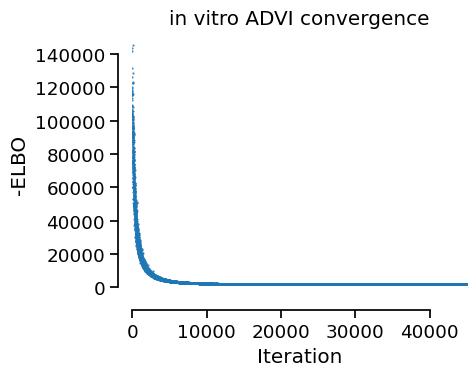

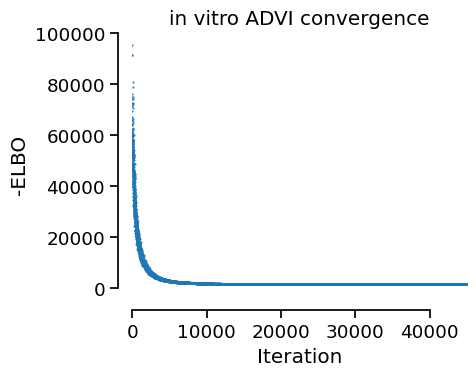

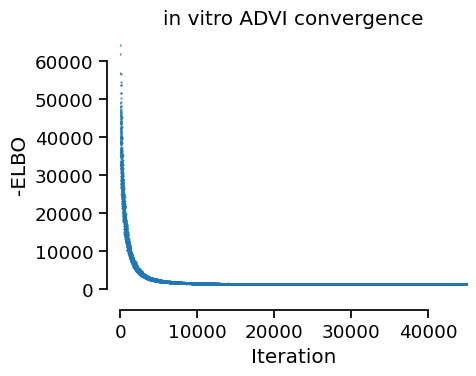

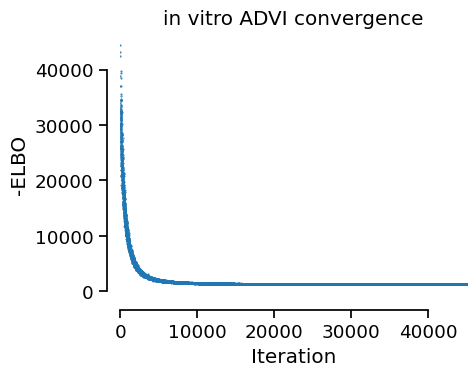

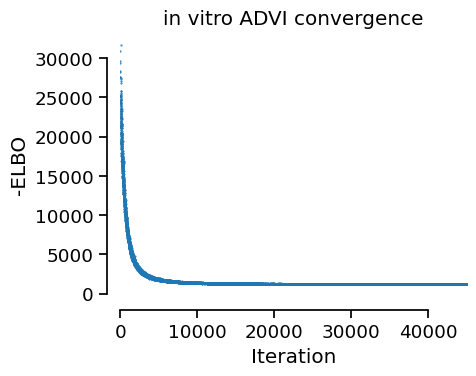

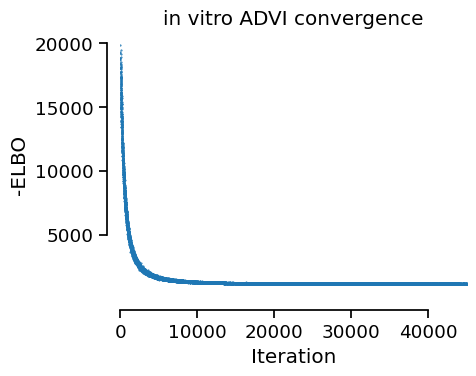

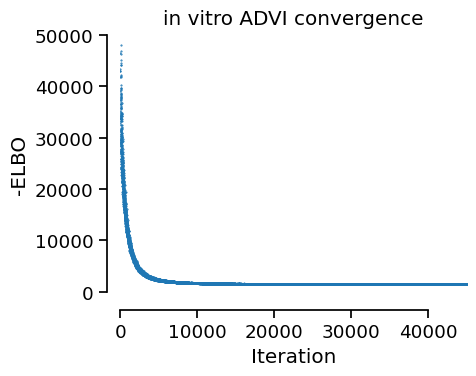

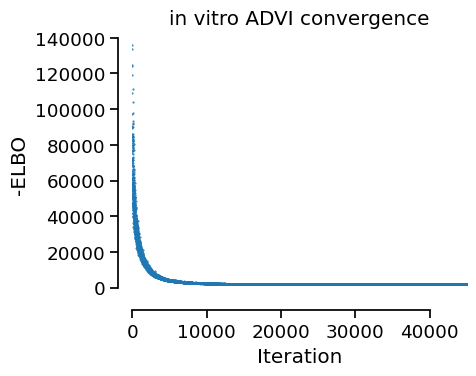

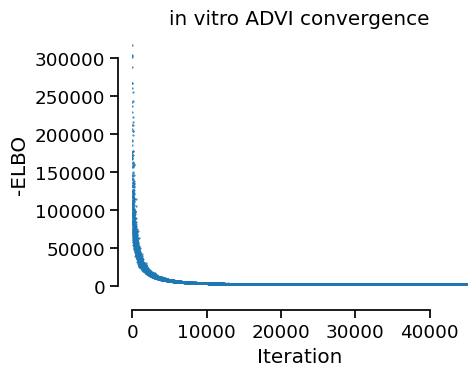

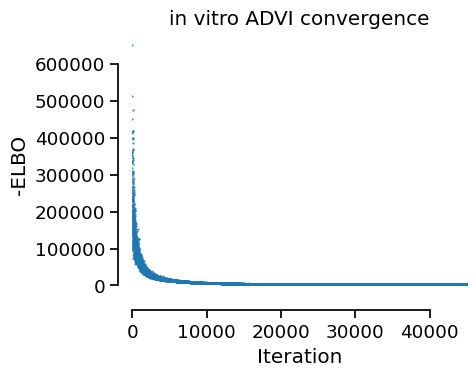

In [9]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)

trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)

### saving trace data

In [10]:
with gzip.open("topologyB-reg2_allData_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [10]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyB-reg2_allData_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [11]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

### Elasticity check 

In [12]:
Ex01_advi = util.get_az_summary(trace01)
Ex02_advi = util.get_az_summary(trace02)
Ex03_advi = util.get_az_summary(trace03)
Ex04_advi = util.get_az_summary(trace04)
Ex05_advi = util.get_az_summary(trace05)

Ex15_advi = util.get_az_summary(trace15)
Ex3_advi = util.get_az_summary(trace3)
Ex5_advi = util.get_az_summary(trace5)
Ex7_advi = util.get_az_summary(trace7)
Ex100_advi = util.get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [13]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                Ex01_advi, Ex02_advi, Ex03_advi, 
                               Ex04_advi, Ex05_advi,  
                               Ex15_advi, Ex3_advi, Ex5_advi, 
                               Ex7_advi, Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-reg2_allData_elasticities.csv')

In [14]:
elasticities_df.loc['v5_H']

gt     -0.566801
0.1x   -0.081000
0.2x   -0.043000
0.3x   -0.027000
0.4x   -0.013000
0.5x   -0.012000
1.5x    0.002000
3x     -0.018000
5x     -0.031000
7x     -0.043000
10x    -0.039000
Name: v5_H, dtype: float64

In [15]:
elasticities_df.loc['v14_O']

gt     -0.439459
0.1x   -0.021000
0.2x   -0.006000
0.3x    0.005000
0.4x   -0.001000
0.5x   -0.012000
1.5x    0.008000
3x      0.013000
5x      0.020000
7x      0.018000
10x     0.043000
Name: v14_O, dtype: float64

In [14]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

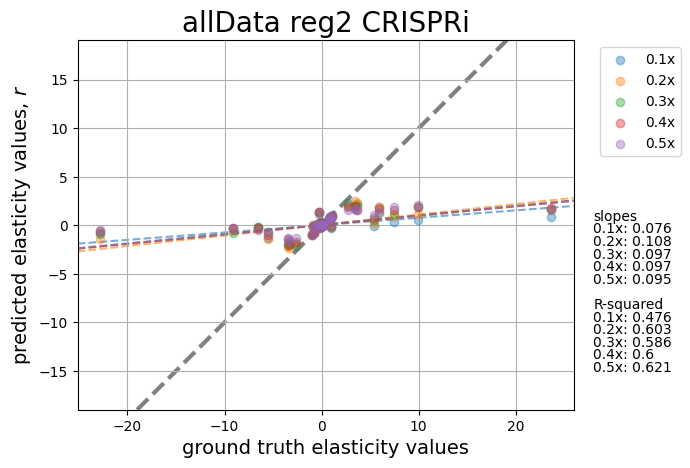

In [16]:
plt.axes().set_aspect('equal', 'datalim')
#plt.scatter(elasticities_df['gt'], elasticities_df['knockout'], alpha=0.4, label='knockout', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData reg2 CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 28
line_spacing = 1.3
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

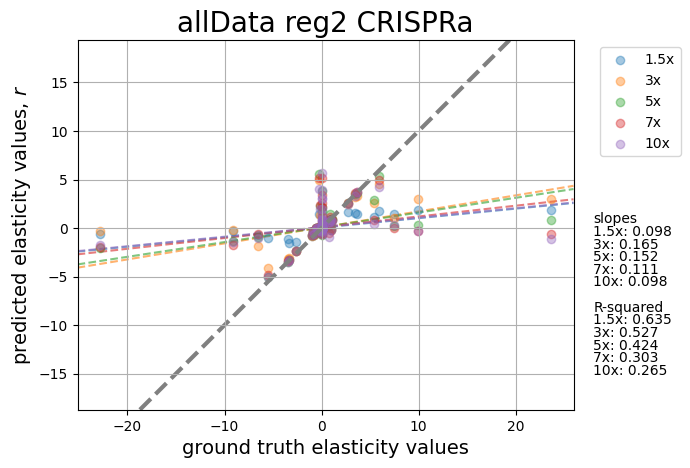

In [17]:
plt.axes().set_aspect('equal', 'datalim')
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData reg2 CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 28
line_spacing = 1.3
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[5:10]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+5]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[5:10]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+5]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+5]), slope=e_slopes[i+5], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

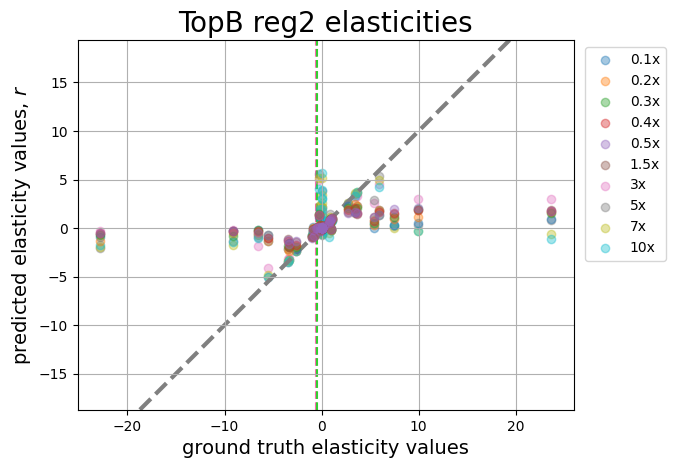

In [15]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='hotpink', linestyle='dashed', zorder=0)
plt.axvline(x=elasticities_df.loc['v14_O']['gt'], c='limegreen', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title(f'Top{topology} {omission} elasticities', size=20)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

left_adjust = 2.8
line_spacing = 0.12
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

"""plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)"""

plt.savefig(f'../../../data/results/raw_svg_figures/top{topology}/elasticities/top{topology}-{omission}-elasticities.svg', format="svg")

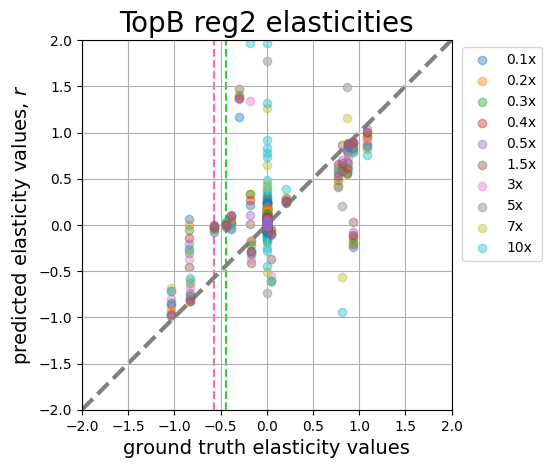

In [17]:
plt.axes().set_aspect('equal')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='hotpink', linestyle='dashed', zorder=0)
plt.axvline(x=elasticities_df.loc['v14_O']['gt'], c='limegreen', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)

plt.xlim(-2,2)
plt.ylim(-2,2)

plt.title(f'Top{topology} {omission} elasticities', size=20)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

left_adjust = 2.8
line_spacing = 0.12
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

"""plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)"""

plt.savefig(f'../../../data/results/raw_svg_figures/top{topology}/elasticities/top{topology}-{omission}-elasticities-zoomed.svg', format="svg")

### ANOVA

In [13]:
# running ANOVA on differences btw gt and predicted
# elasticities_df = elasticities_df.sub(elasticities_df['gt'], axis=0)
stats.f_oneway(elasticities_df['0.1x'],
                elasticities_df['0.2x'],
                elasticities_df['0.3x'],
                elasticities_df['0.4x'],
                elasticities_df['0.5x'],
                elasticities_df['1.5x'],
                elasticities_df['3x'],
                elasticities_df['5x'],
                elasticities_df['7x'],
                elasticities_df['10x'])

F_onewayResult(statistic=0.35940157755141344, pvalue=0.954148774806443)

In [18]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt      0.000000
0.1x    0.441668
0.2x    0.417850
0.3x    0.421789
0.4x    0.420510
0.5x    0.422045
1.5x    0.418414
3x      0.374259
5x      0.427896
7x      0.485438
10x     0.520606
dtype: float64

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

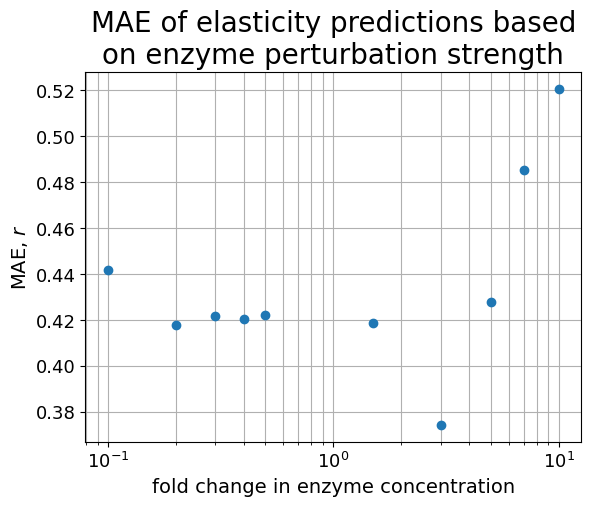

In [19]:
# print out MAE for each perturbation strength

plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

In [20]:
MAE.to_csv('topologyB-reg2_allData_MAE.csv')

## Calculating FCCs

In [21]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

### Negative predictions

In [22]:
Ex01_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex02_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj02)['prior']['Ex'])
Ex03_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj03)['prior']['Ex'])
Ex04_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj04)['prior']['Ex'])
Ex05_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj05)['prior']['Ex'])

Ex15_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj15)['prior']['Ex'])
Ex3_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj3)['prior']['Ex'])
Ex5_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj5)['prior']['Ex'])
Ex7_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj7)['prior']['Ex'])
Ex100_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj100)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

In [23]:
priorFCC01 = util.estimate_FCCs(BMCA_obj01, Ex01_prior.reshape((19,-1)))
priorFCC02 = util.estimate_FCCs(BMCA_obj02, Ex02_prior.reshape((19,-1)))
priorFCC03 = util.estimate_FCCs(BMCA_obj03, Ex03_prior.reshape((19,-1)))
priorFCC04 = util.estimate_FCCs(BMCA_obj04, Ex04_prior.reshape((19,-1)))
priorFCC05 = util.estimate_FCCs(BMCA_obj05, Ex05_prior.reshape((19,-1)))

priorFCC15 = util.estimate_FCCs(BMCA_obj15, Ex15_prior.reshape((19,-1)))
priorFCC3 = util.estimate_FCCs(BMCA_obj3, Ex3_prior.reshape((19,-1)))
priorFCC5 = util.estimate_FCCs(BMCA_obj5, Ex5_prior.reshape((19,-1)))
priorFCC7 = util.estimate_FCCs(BMCA_obj7, Ex7_prior.reshape((19,-1)))
priorFCC100 = util.estimate_FCCs(BMCA_obj100, Ex100_prior.reshape((19,-1)))


In [24]:
postFCC01 = util.estimate_FCCs(BMCA_obj01, Ex01_advi.reshape((19,13)))
postFCC02 = util.estimate_FCCs(BMCA_obj02, Ex02_advi.reshape((19,13)))
postFCC03 = util.estimate_FCCs(BMCA_obj03, Ex03_advi.reshape((19,13)))
postFCC04 = util.estimate_FCCs(BMCA_obj04, Ex04_advi.reshape((19,13)))
postFCC05 = util.estimate_FCCs(BMCA_obj05, Ex05_advi.reshape((19,13)))

postFCC15 = util.estimate_FCCs(BMCA_obj15, Ex15_advi.reshape((19,13)))
postFCC3 = util.estimate_FCCs(BMCA_obj3, Ex3_advi.reshape((19,13)))
postFCC5 = util.estimate_FCCs(BMCA_obj5, Ex5_advi.reshape((19,13)))
postFCC7 = util.estimate_FCCs(BMCA_obj7, Ex7_advi.reshape((19,13)))
postFCC100 = util.estimate_FCCs(BMCA_obj100, Ex100_advi.reshape((19,13)))

In [25]:
prior_FCCs = [priorFCC01, priorFCC02, priorFCC03, priorFCC04, priorFCC05, priorFCC15, priorFCC3, priorFCC5, priorFCC7, priorFCC100]
post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]

In [27]:
priorFCC_noReg_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for priorFCC in prior_FCCs]
priorFCC_noReg_meds = pd.concat([i.melt()['value'] for i in priorFCC_noReg_meds], axis=1).values
priorFCC_noReg_meds = pd.DataFrame(priorFCC_noReg_meds, columns=pt_labels)
priorFCC_noReg_meds['median'] = priorFCC_noReg_meds.median(axis=1)
priorFCC_noReg_meds['min'] = priorFCC_noReg_meds.min(axis=1)
priorFCC_noReg_meds['max'] = priorFCC_noReg_meds.max(axis=1)
# priorFCC_noReg_meds

FCC_lower_y_noReg_prior = np.array(priorFCC_noReg_meds['median']) - np.array(priorFCC_noReg_meds['min'])
FCC_upper_y_noReg_prior = np.array(priorFCC_noReg_meds['max']) - np.array(priorFCC_noReg_meds['median'])
FCC_errors_noReg_prior = [FCC_lower_y_noReg_prior, FCC_upper_y_noReg_prior]

In [28]:
postFCC_noReg_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for postFCC in post_FCCs]
postFCC_noReg_meds = pd.concat([i.melt()['value'] for i in postFCC_noReg_meds], axis=1).values
postFCC_noReg_meds = pd.DataFrame(postFCC_noReg_meds, columns=pt_labels)
postFCC_noReg_meds['median'] = postFCC_noReg_meds.median(axis=1)
postFCC_noReg_meds['min'] = postFCC_noReg_meds.min(axis=1)
postFCC_noReg_meds['max'] = postFCC_noReg_meds.max(axis=1)
# postFCC_noReg_meds

FCC_lower_y_noReg_post = np.array(postFCC_noReg_meds['median']) - np.array(postFCC_noReg_meds['min'])
FCC_upper_y_noReg_post = np.array(postFCC_noReg_meds['max']) - np.array(postFCC_noReg_meds['median'])
FCC_errors_noReg_post = [FCC_lower_y_noReg_post, FCC_upper_y_noReg_post]

## FCC graphs

Text(0, 0.5, 'predicted FCC values')

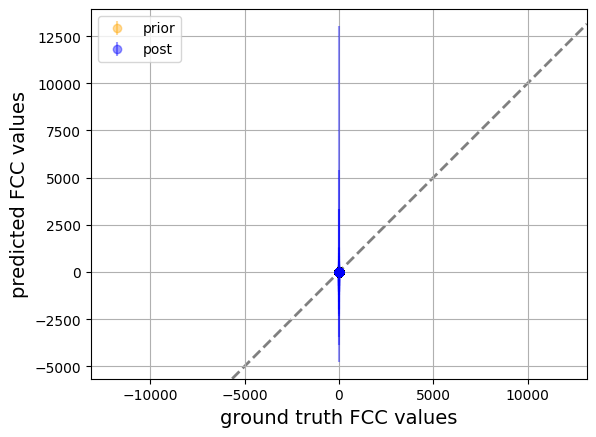

In [29]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_noReg_meds['median'], yerr=FCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_noReg.svg', format="svg")

Text(0, 0.5, 'predicted FCC values')

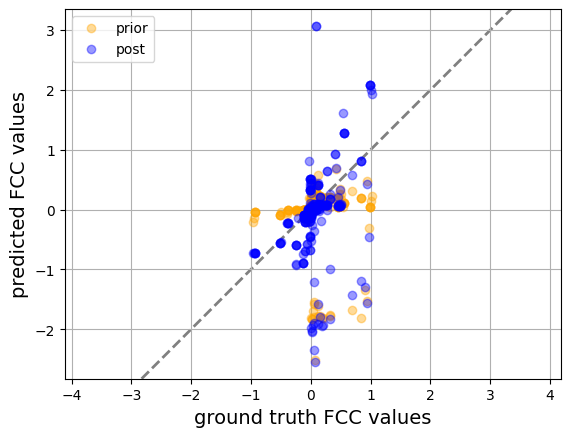

In [30]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_noReg_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_noReg.svg', format="svg")

### adding corrections for where the enzyme perturbed is directly involved in the reaction

In [31]:
rxn = np.repeat(r.getReactionIds(),len(r.getReactionIds()))
enz_pt = r.getReactionIds() * len(r.getReactionIds())
FCC_idx = pd.DataFrame([rxn, enz_pt]).T

In [32]:
pt_enz_is_rxn = np.linspace(0,len(rxn)-1,len(r.getReactionIds()))
pt_enz_is_rxn

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 320., 340., 360.])

### graphing the corrected FCC dfs

In [33]:
priorFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_noReg_meds.loc[pt_enz_is_rxn, 'median'] += 2

Text(0, 0.5, 'predicted FCC values')

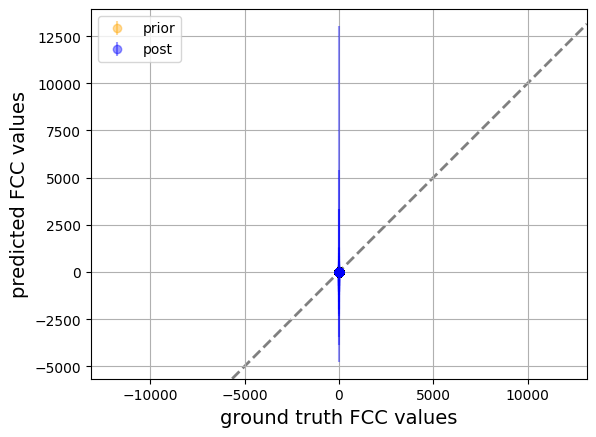

In [34]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_noReg_meds['median'], yerr=FCC_errors_noReg_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_noReg_meds['median'], yerr=FCC_errors_noReg_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_noReg_wCorrection.svg', format="svg")

Text(0, 0.5, 'predicted FCC values')

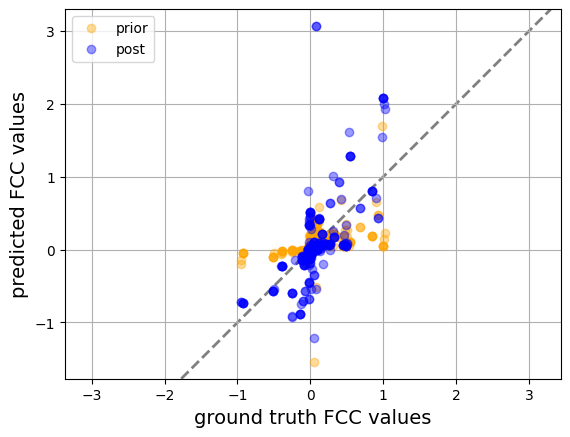

In [35]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_noReg_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_noReg_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_noReg_wCorrection.svg', format="svg")

In [26]:
prd_priorFCCs = pd.concat([util.append_FCC_df(prior_FCCs[i], pt_labels[i],r) for i in range(len(prior_FCCs))])
prd_postFCCs = pd.concat([util.append_FCC_df(post_FCCs[i], pt_labels[i],r) for i in range(len(post_FCCs))])

## Evaluating FCC ranking

In [20]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v19']

### via Spearman rank coefficients

In [21]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [22]:
pt_labels = [i+'-prior' for i in pt_labels] + [i+'-post' for i in pt_labels]


In [23]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.1x-prior,0.170279,0.499341,-0.458357,0.672707
0.2x-prior,0.164087,0.515295,-0.451157,0.674991
0.3x-prior,0.093911,0.710899,-0.491198,0.651436
0.4x-prior,0.145511,0.564541,-0.494425,0.617969
0.5x-prior,0.141383,0.575754,-0.461075,0.650298
1.5x-prior,0.137255,0.587062,-0.387788,0.653919
3x-prior,0.205366,0.413635,-0.326372,0.677802
5x-prior,0.333333,0.176463,-0.221382,0.701928
7x-prior,0.252838,0.311413,-0.334834,0.703874
10x-prior,0.345717,0.159953,-0.170873,0.750000


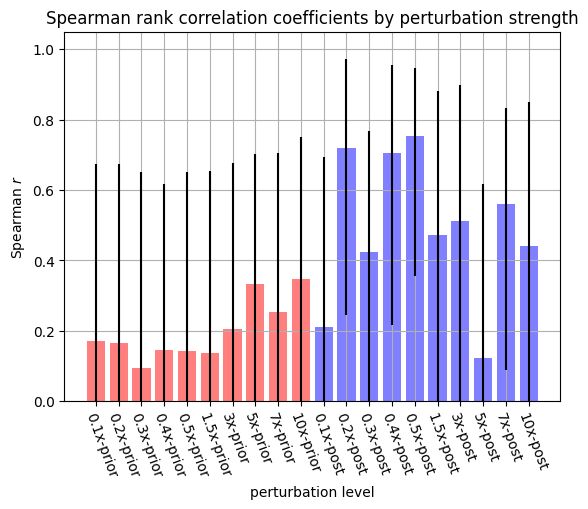

In [24]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']*10 + ['b']*10)
plt.grid()

for i, txt in enumerate(spearman_df['r']):
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color='k')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

_=plt.xticks(rotation=-70,ha='left',rotation_mode="anchor")

In [25]:
spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyB-reg2_allData_spr.csv')

### evaluating top 10 rankings

In [26]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v19') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v19')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,...,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
v19,,,,,,,,,,,,,,,,,,,,,
1.0,v18,v18,v18,v18,v18,v18,v18,v18,v18,v18,...,v14,v18,v18,v18,v18,v3,v18,v18,v5,v5
2.0,v1,v14,v14,v16,v14,v14,v15,v15,v15,v15,...,v1,v1,v14,v1,v1,v2,v1,v15,v4,v7
3.0,v7,v17,v16,v17,v16,v17,v14,v5,v5,v5,...,v16,v14,v1,v14,v14,v1,v5,v5,v7,v4
4.0,v14,v16,v17,v14,v17,v16,v16,v4,v4,v4,...,v2,v2,v8,v2,v3,v18,v2,v6,v9,v9
5.0,v5,v15,v15,v15,v15,v15,v17,v6,v7,v6,...,v18,v7,v13,v7,v7,v7,v15,v9,v1,v1
6.0,v4,v8,v8,v8,v8,v8,v8,v17,v6,v7,...,v17,v5,v3,v8,v8,v14,v3,v17,v6,v6
7.0,v9,v13,v13,v13,v13,v13,v5,v16,v1,v1,...,v7,v3,v15,v5,v2,v9,v4,v16,v2,v2
8.0,v3,v4,v4,v4,v4,v4,v4,v7,v17,v16,...,v15,v4,v7,v4,v13,v8,v7,v14,v14,v12
9.0,v8,v1,v1,v1,v1,v1,v13,v1,v16,v17,...,v4,v8,v9,v13,v9,v10,v16,v12,v16,v14


In [27]:
q.to_csv('../../../data/results/rankings/topologyB-reg2_allData_rankings.csv')

In [28]:
rank_df = pd.read_csv('../../../data/results/rankings/topologyB-reg2_allData_rankings.csv')

In [29]:
topTen_df = rank_df[rank_df['v19'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,10x-prior,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
0,6,6,6,6,6,6,6,6,6,7,6,9,7,8,8,7,7,6,7,7


In [30]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([11, 14, 15, 17], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([12, 14, 17], dtype='int64')
Int64Index([14, 15, 16, 17], dtype='int64')
Int64Index([16], dtype='int64')
Int64Index([11, 14, 16], dtype='int64')
Int64Index([11, 16], dtype='int64')
Int64Index([11, 16], dtype='int64')
Int64Index([10, 12, 16], dtype='int64')
Int64Index([14, 15, 16], dtype='int64')
Int64Index([12, 14, 15, 17], dtype='int64')
Int64Index([12, 15, 16], dtype='int64')
Int64Index([10, 12, 16], dtype='int64')
